### Importing libraries

In [13]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import text

### Importing Dataset

In [14]:
df = pd.read_csv('data/reviews_with_sentiment.csv')
df.head()

,reviews,category
0,I thought it would be as big as small paper bu...,0
1,This kindle is light and easy to use especiall...,1
2,Didnt know how much i'd use a kindle so went f...,1
3,I am 100 happy with my purchase. I caught it o...,1
4,Solid entry level Kindle. Great for kids. Gift...,1


### Preprocessing (tokenizer, padding, train-test split)

In [15]:
# Preprocessing cell (Cell 14)
# Extract reviews and labels
reviews = df['reviews'].values
labels = df['category'].values

import numpy as np
# Add 1 to all labels to shift from [-1, 0, 1] to [0, 1, 2]
labels = labels + 1

# Compute class weights to counter imbalance
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', 
                                    classes=unique_classes,
                                    y=labels)
class_weight_dict = {i: weight for i, weight in zip(unique_classes, class_weights)}
print("Class weights:", class_weight_dict)

# Tokenize the reviews
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Pad sequences
max_length = 100
X = pad_sequences(sequences, maxlen=max_length)

# Convert labels to numpy array
y = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=labels)

Class weights: {0: 14.245014245014245, 1: 8.460236886632826, 2: 0.3556693697538768}


### Building the Model's Architecture

In [16]:
max_length = 100

model = Sequential()

model.add(Embedding(input_dim=5000, output_dim=100, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.build(input_shape=(None, max_length))

model.summary()

/Users/utksahu2/Downloads/batch2-v2/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 587,059 (2.24 MB)

 Trainable params: 587,059 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Model

In [17]:

epochs = 30
batch_size = 64

# Pass the class_weight parameter to the fit method
history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)],
    class_weight=class_weight_dict  # Add this line
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8371 - loss: 1.0658 - val_accuracy: 0.9350 - val_loss: 0.9446
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8557 - loss: 89665388544.0000 - val_accuracy: 0.8930 - val_loss: 0.8139
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8766 - loss: 38525247488.0000 - val_accuracy: 0.7340 - val_loss: 0.8500
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8199 - loss: 0.8522 - val_accuracy: 0.8260 - val_loss: 0.7130
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8541 - loss: 0.7527 - val_accuracy: 0.8290 - val_loss: 0.6206
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8652 - loss: 0.5858 - val_accuracy: 0.8220 - val_loss: 0.5617
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8841 - loss: 492.2111 - val_accuracy: 0.8560 - val_loss: 0.4895
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9070 - loss: 0.4260 -

In [18]:
from sklearn.metrics import balanced_accuracy_score
y_pred = np.argmax(model.predict(X_test), axis=1)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced accuracy: {balanced_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Balanced accuracy: 0.5230085997556184


### Evaluating the model 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8378 - loss: 258.2983
Test score: 282.07476806640625
Test accuracy: 0.8209999799728394
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


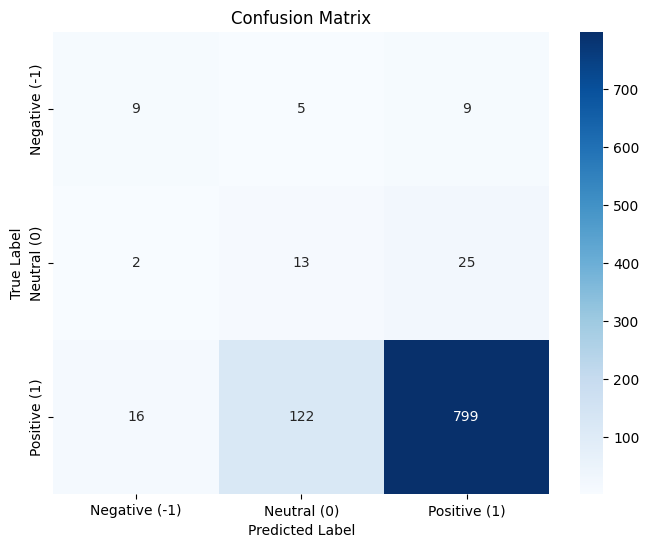

Classification Report:
               precision    recall  f1-score   support

Negative (-1)       0.33      0.39      0.36        23
  Neutral (0)       0.09      0.33      0.14        40
 Positive (1)       0.96      0.85      0.90       937

     accuracy                           0.82      1000
    macro avg       0.46      0.52      0.47      1000
 weighted avg       0.91      0.82      0.86      1000



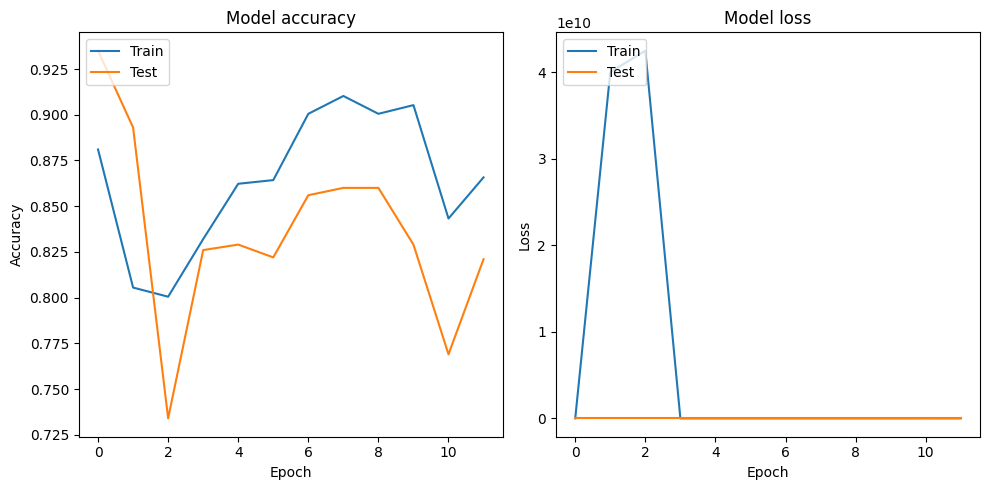

In [19]:
import matplotlib.pyplot as plt

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'Test score: {score}')
print(f'Test accuracy: {acc}')

# Add detailed evaluation metrics for the three categories
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Get predictions on test data
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Map back to original sentiment values for better interpretability
# Remember we added +1 to convert [-1, 0, 1] to [0, 1, 2], so now we map back for display
original_labels = {0: "Negative (-1)", 1: "Neutral (0)", 2: "Positive (1)"}

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[original_labels[i] for i in range(3)],
            yticklabels=[original_labels[i] for i in range(3)])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=[original_labels[i] for i in range(3)]))

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.show()

### Predictive Model

In [20]:
# Predict sentiment for new reviews
new_reviews = ["This product is great!", "I didn't like this item.", "It's okay, nothing special.","I was looking for a kindle whitepaper. I saw online for $80. What a deal. I ordered it on line and picked it up in the store. I got it home and couldn't adjust the brightness. After a lengthy time with online customer service I called customer service. After 20 minuets with speaking to a female Elmer Fud that doesn't speak english well I figured I would just return it. Although it looks Identical to the $120 model, you can not adjust the brightness. That would have been good information before I bought it."]
sequences = tokenizer.texts_to_sequences(new_reviews)
padded_sequences = pad_sequences(sequences, maxlen=max_length)
predictions = model.predict(padded_sequences)
# Get the class with highest probability for each prediction
predicted_classes = np.argmax(predictions, axis=1)

# Map predicted classes back to original sentiment labels
# Remember we added +1 to convert [-1, 0, 1] to [0, 1, 2], so now we convert back
original_sentiment_map = {0: -1, 1: 0, 2: 1}  # Map back to original values
original_sentiment_labels = [original_sentiment_map[cls] for cls in predicted_classes]

# Map sentiment values to human-readable text
sentiment_text_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
predicted_text_labels = [sentiment_text_map[label] for label in original_sentiment_labels]

# Print the results
for review, pred_text, sentiment_value in zip(new_reviews, predicted_text_labels, original_sentiment_labels):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {pred_text} ({sentiment_value})")
    print()

print("Raw prediction probabilities:")
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Review: This product is great!
Predicted Sentiment: Positive (1)

Review: I didn't like this item.
Predicted Sentiment: Negative (-1)

Review: It's okay, nothing special.
Predicted Sentiment: Positive (1)

Review: I was looking for a kindle whitepaper. I saw online for $80. What a deal. I ordered it on line and picked it up in the store. I got it home and couldn't adjust the brightness. After a lengthy time with online customer service I called customer service. After 20 minuets with speaking to a female Elmer Fud that doesn't speak english well I figured I would just return it. Although it looks Identical to the $120 model, you can not adjust the brightness. That would have been good information before I bought it.
Predicted Sentiment: Negative (-1)

Raw prediction probabilities:
[[0.04200927 0.5973743  0.77354085]
 [0.65663886 0.49762866 0.3261892 ]
 [0.11274856 0.55547714 0.6906748 ]
 [0.9251565  0.3602434  0.16421491]]


### Persisting the Model and Tokenizer

In [21]:
model.save('weights/lstm_model.h5')

In [12]:
import pickle


with open('weights/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)


## Thank You